# Exploratory Analysis of Spatial Data: Spatial Autocorrelation 


In this notebook we introduce methods of _exploratory spatial data analysis_
that are intended to complement geovizualization through formal univariate and
multivariate statistical tests for spatial clustering.


## Imports

In [1]:
import esda
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
%matplotlib inline

Our data set comes from the Berlin airbnb scrape taken in April 2018. This dataframe was constructed as part of the [GeoPython 2018 workshop](https://github.com/ljwolf/geopython) by [Levi Wolf](https://ljwolf.org) and [Serge Rey](https://sergerey.org). As part of the workshop a geopandas data frame was constructed with one of the columns reporting the median listing price of units in each neighborhood in Berlin:

In [2]:
gdf = gpd.read_file('data/berlin-neighbourhoods.geojson')


In [3]:
bl_df = pd.read_csv('data/berlin-listings.csv')
geometry = [Point(xy) for xy in zip(bl_df.longitude, bl_df.latitude)]
crs = {'init': 'epsg:4326'} 
bl_gdf = GeoDataFrame(bl_df, crs=crs, geometry=geometry)


In [4]:
bl_gdf['price'] = bl_gdf['price'].astype('float32')
sj_gdf = gpd.sjoin(gdf, bl_gdf, how='inner', op='intersects', lsuffix='left', rsuffix='right')
median_price_gb = sj_gdf['price'].groupby([sj_gdf['neighbourhood_group']]).mean()
median_price_gb

neighbourhood_group
Charlottenburg-Wilm.        58.556408
Friedrichshain-Kreuzberg    55.492809
Lichtenberg                 44.584270
Marzahn - Hellersdorf       54.246754
Mitte                       60.387890
Neukölln                    45.135948
Pankow                      60.282516
Reinickendorf               43.682465
Spandau                     48.236561
Steglitz - Zehlendorf       54.445683
Tempelhof - Schöneberg      53.704407
Treptow - Köpenick          51.222004
Name: price, dtype: float32

In [5]:
gdf = gdf.join(median_price_gb, on='neighbourhood_group')
gdf.rename(columns={'price': 'median_pri'}, inplace=True)
gdf.head(15)

,neighbourhood,neighbourhood_group,geometry,median_pri
0,Blankenfelde/Niederschönhausen,Pankow,"(POLYGON ((13.411909 52.614871, 13.411826 52.6...",60.282516
1,Helmholtzplatz,Pankow,"(POLYGON ((13.414053 52.549288, 13.414222 52.5...",60.282516
2,Wiesbadener Straße,Charlottenburg-Wilm.,"(POLYGON ((13.307476 52.467882, 13.307434 52.4...",58.556408
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,"(POLYGON ((13.709727 52.396299, 13.709263 52.3...",51.222004
4,Müggelheim,Treptow - Köpenick,"(POLYGON ((13.737622 52.408498, 13.737734 52.4...",51.222004
5,Biesdorf,Marzahn - Hellersdorf,"(POLYGON ((13.566433 52.535103, 13.566974 52.5...",54.246754
6,Nord 1,Reinickendorf,"(POLYGON ((13.336686 52.622651, 13.336632 52.6...",43.682465
7,West 5,Reinickendorf,"(POLYGON ((13.281381 52.59958, 13.281575 52.59...",43.682465
8,Frankfurter Allee Nord,Friedrichshain-Kreuzberg,"(POLYGON ((13.453201 52.51682, 13.453212 52.51...",55.492809
9,Buch,Pankow,"(POLYGON ((13.464495 52.650553, 13.464566 52.6...",60.282516


We have an `nan` to first deal with:

In [6]:
pd.isnull(gdf['median_pri']).sum()

2

In [7]:
gdf['median_pri'].fillna((gdf['median_pri'].mean()), inplace=True)

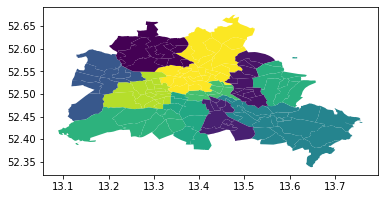

In [8]:
gdf.plot(column='median_pri')

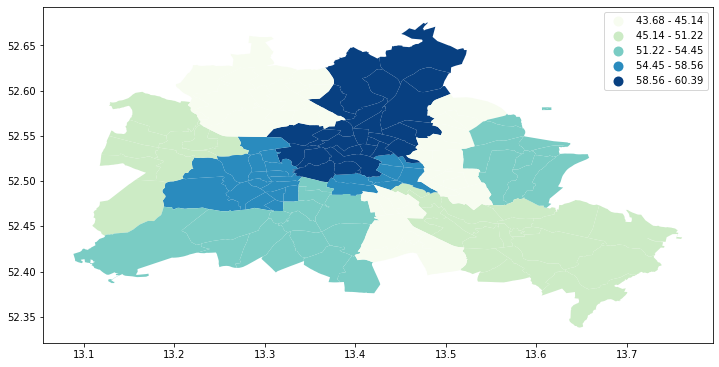

In [9]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
gdf.plot(column='median_pri', scheme='Quantiles', k=5, cmap='GnBu', legend=True, ax=ax)
#ax.set_xlim(150000, 160000)
#ax.set_ylim(208000, 215000)

## Spatial Autocorrelation ##

Visual inspection of the map pattern for the prices allows us to search for
spatial structure. If the spatial distribution of the prices was random, then we
should not see any clustering of similar values on the map. However, our visual
system is drawn to the darker clusters in the south west as well as the center,
and a concentration of the lighter hues (lower prices) in the north central and
south east.

Our brains are very powerful pattern recognition machines. However, sometimes
they can be too powerful and lead us to detect false positives, or patterns
where there are no statistical patterns. This is a particular concern when
dealing with visualization of irregular polygons of differning sizes and shapes.

The concept of *spatial
autocorrelation* relates to the combination of two types of similarity: spatial
similarity and attribute similarity. Although there are many different measures
of spatial autocorrelation, they all combine these two types of simmilarity into
a summary measure.

Let's use PySAL to generate these two types of similarity
measures.

### Spatial Similarity ###

We have already encountered spatial weights
in a previous notebook. In spatial autocorrelation analysis, the spatial weights
are used to formalize the notion of spatial similarity. As we have seen there
are many ways to define spatial weights, here we will use queen contiguity:

In [10]:
df = gdf
wq =  lps.weights.Queen.from_dataframe(df)
wq.transform = 'r'

/home/serge/anaconda3/envs/esda/lib/python3.7/site-packages/libpysal/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


### Attribute Similarity ###

So the spatial weight between neighborhoods $i$ and $j$ indicates if the two 
are neighbors (i.e., geographically similar). What we also need is a measure of
attribute similarity to pair up with this concept of spatial similarity. The
**spatial lag** is a derived variable that accomplishes this for us. For neighborhood
$i$ the spatial lag is defined as: $$ylag_i = \sum_j w_{i,j} y_j$$

In [11]:
y = df['median_pri']
ylag = lps.weights.lag_spatial(wq, y)

In [12]:
ylag

array([56.9625061 , 60.28251648, 56.37749926, 51.22200394, 51.22200394,
       50.52180099, 43.6824646 , 45.63422012, 52.65491422, 60.28251648,
       53.64180374, 52.73586273, 52.73586273, 56.47182541, 47.83247757,
       58.58870177, 60.33520317, 59.60296903, 60.38788986, 60.02159348,
       51.80624199, 57.94034958, 52.84482813, 53.40314266, 57.90522512,
       60.28251648, 60.28251648, 55.79730334, 56.79401737, 50.81182589,
       59.01427841, 60.29756982, 60.28251648, 50.86356888, 60.3220315 ,
       60.28251648, 55.48057556, 54.42881557, 60.32466583, 59.50179418,
       54.42846909, 58.55640793, 58.55640793, 57.73426285, 57.47818544,
       57.74774106, 56.13040733, 48.23656082, 48.23656082, 53.74621709,
       55.11957245, 45.95951271, 51.67650986, 54.1985906 , 51.45368042,
       52.36880302, 54.44568253, 54.44568253, 50.84825389, 56.50104523,
       53.92108345, 55.9956289 , 50.49590378, 49.14499828, 48.61369433,
       49.70049   , 49.32550866, 51.22200394, 51.22200394, 47.80

In [13]:
import mapclassify as mc
ylagq5 = mc.Quantiles(ylag, k=5)

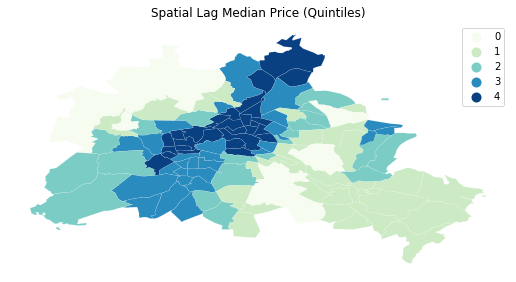

In [14]:
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, \
        k=5, cmap='GnBu', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag Median Price (Quintiles)")

plt.show()

The quintile map for the spatial lag tends to enhance the impression of value
similarity in space. It is, in effect, a local smoother.

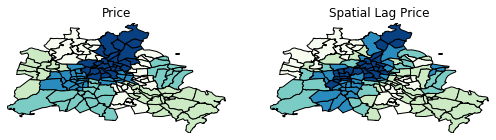

In [15]:
df['lag_median_pri'] = ylag
f,ax = plt.subplots(1,2,figsize=(2.16*4,4))
df.plot(column='median_pri', ax=ax[0], edgecolor='k',
        scheme="quantiles",  k=5, cmap='GnBu')
ax[0].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Price")
df.plot(column='lag_median_pri', ax=ax[1], edgecolor='k',
        scheme='quantiles', cmap='GnBu', k=5)
ax[1].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Price")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

However, we still have
the challenge of visually associating the value of the prices in a neighborhod
with the value of the spatial lag of values for the focal unit. The latter is a
weighted average of homicide rates in the focal county's neighborhood.

To complement the geovisualization of these associations we can turn to formal
statistical measures of spatial autocorrelation.


## Global Spatial Autocorrelation

We begin with a simple case where the variable under consideration is binary.
This is useful to unpack the logic of spatial autocorrelation tests. So  even though
our attribute is a continuously valued one, we will convert it to a binary case
to illustrate the key concepts:

### Binary Case

In [16]:
y.median()


53.704407

In [17]:
yb = y > y.median()
sum(yb)

68

We have 68 neighborhoods with list prices above the median and 70 below the
median (recall the issue with ties).

In [18]:
yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb] 
df['yb'] = yb

The spatial distribution of the binary variable immediately raises questions
about the juxtaposition of the "black" and "white" areas.

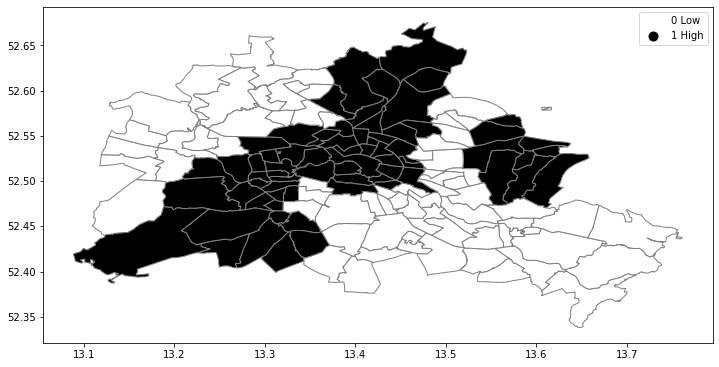

In [19]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)

### Join counts ###

One way to formalize a test for spatial autocorrelation in a binary attribute is
to consider the so-called _joins_. A join exists for each neighbor pair of
observations, and the joins are reflected in our binary spatial weights object
`wq`. 

Each unit can take on one of two values "Black" or "White", and so for a given
pair of neighboring locations there are three different types of joins that can
arise:

- Black Black (BB)
- White White (WW)
- Black White (or White Black) (BW)

Given that we have 68 Black polygons on our map, what is the number of Black
Black (BB) joins we could expect if the process were such that the Black
polygons were randomly assigned on the map? This is the logic of join count statistics.

We can use the `esda` package from PySAL to carry out join count analysis:

In [20]:
import esda 
yb = 1 * (y > y.median()) # convert back to binary
wq =  lps.weights.Queen.from_dataframe(df)
wq.transform = 'b'
np.random.seed(12345)
jc = esda.join_counts.Join_Counts(yb, wq)

[[ 89.03626943 102.96373057]
 [ 89.96373057 104.03626943]]


The resulting object stores the observed counts for the different types of joins:

In [21]:
jc.bb

164

In [22]:
jc.ww

149

In [23]:
jc.bw

73

Note that the three cases exhaust all possibilities:

In [24]:
jc.bb + jc.ww + jc.bw

386

and

In [25]:
wq.s0 / 2

386.0

which is the unique number of joins in the spatial weights object.

Our object tells us we have observed 121 BB joins:

In [26]:
jc.bb

164

The critical question for us, is whether this is a departure from what we would
expect if the process generating the spatial distribution of the Black polygons
were a completely random one? To answer this, PySAL uses random spatial
permutations of the observed attribute values to generate a realization under
the null of _complete spatial randomness_ (CSR). This is repeated a large number
of times (999 default) to construct a reference distribution to evaluate the
statistical significance of our observed counts.

The average number of BB joins from the synthetic realizations is:

In [27]:
jc.mean_bb

90

which is less than our observed count. The question is whether our observed
value is so different from the expectation that we would reject the null of CSR?

Text(0.5, 0, 'BB Counts')

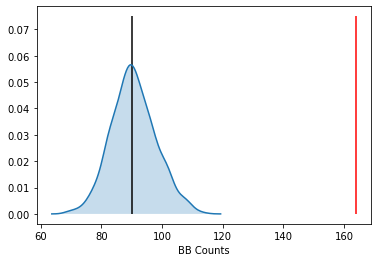

In [28]:
import seaborn as sbn
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')


The density portrays the distribution of the BB counts, with the black vertical
line indicating the mean BB count from the synthetic realizations and the red
line the observed BB count for our prices. Clearly our observed value is
extremely high. A pseudo p-value summarizes this:

In [29]:
jc.p_sim_bb


0.001

Since this is below conventional significance levels, we would reject the null
of complete spatial randomness in favor of spatial autocorrelation in market prices.


### Continuous Case

The join count analysis is based on a binary attribute, which can cover many
interesting empirical applications where one is interested in presence and
absence type phenomena. In our case, we artificially created the binary variable,
and in the process we throw away a lot of information in our originally
continuous attribute. Turning back to the original variable, we can explore
other tests for spatial autocorrelation for the continuous case.

First, we transform our weights to be row-standardized, from the current binary state:

In [30]:
wq.transform = 'r'

In [31]:
y = df['median_pri']

Moran's I is a test for global autocorrelation for a continuous attribute:

In [32]:
np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

0.6563069331329718

Again, our value for the statistic needs to be interpreted against a reference
distribution under the null of CSR. PySAL uses a similar approach as we saw in
the join count analysis: random spatial permutations.

Text(0.5, 0, "Moran's I")

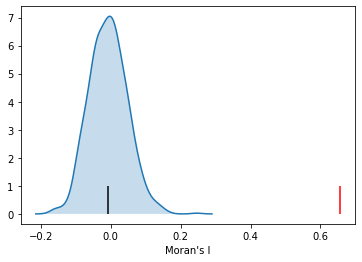

In [33]:
import seaborn as sbn
sbn.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")


Here our observed value is again in the upper tail, although visually it does
not look as extreme relative to the binary case. Yet, it is still statistically significant:

In [34]:
mi.p_sim

0.001

## Local Autocorrelation: Hot Spots, Cold Spots, and Spatial Outliers ##

In addition to the Global autocorrelation statistics, PySAL has many local
autocorrelation statistics. Let's compute a local Moran statistic for the same
d

In [35]:
np.random.seed(12345)
import esda

In [36]:
wq.transform = 'r'
lag_price = lps.weights.lag_spatial(wq, df['median_pri'])


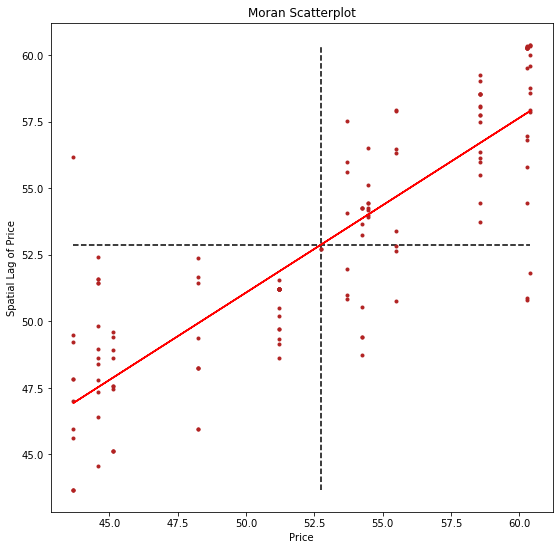

In [37]:
price = df['median_pri']
b, a = np.polyfit(price, lag_price, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(price, lag_price, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(price.mean(), lag_price.min(), lag_price.max(), linestyle='--')
 # dashed horizontal at mean of lagged price 
plt.hlines(lag_price.mean(), price.min(), price.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(price, a + b*price, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Price')
plt.xlabel('Price')
plt.show()


Now, instead of a single $I$ statistic, we have an *array* of local $I_i$
statistics, stored in the `.Is` attribute, and p-values from the simulation are
in `p_sim`.

In [38]:
li = esda.moran.Moran_Local(y, wq)

/home/serge/Dropbox/p/pysal/src/subpackages/esda/esda/moran.py:886: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/home/serge/anaconda3/envs/esda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/serge/anaconda3/envs/esda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/serge/anaconda3/envs/esda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


In [39]:
li.q

array([1, 1, 1, 3, 3, 4, 3, 3, 4, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 4, 1,
       1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 4, 1, 1, 1, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 4, 3, 1,
       1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 4, 3, 4, 1, 3, 3, 3, 3, 3, 4, 3, 3,
       4, 1, 1, 1, 1, 2, 3, 3])

We can again test for local clustering using permutations, but here we use
conditional random permutations (different distributions for each focal location)

In [40]:
(li.p_sim < 0.05).sum()

63

We can distinguish the specific type of local spatial association reflected in
the four quadrants of the Moran Scatterplot above:

In [41]:
sig = li.p_sim < 0.05
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4

In [42]:
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

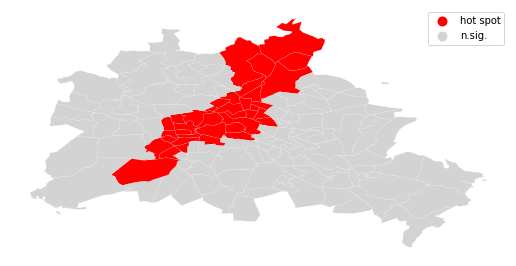

In [43]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [44]:
spots = ['n.sig.', 'cold spot']
labels = [spots[i] for i in coldspot*1]

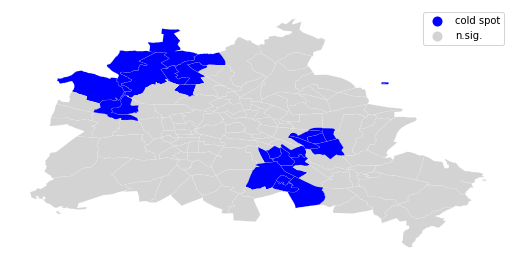

In [45]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [46]:
spots = ['n.sig.', 'doughnut']
labels = [spots[i] for i in doughnut*1]

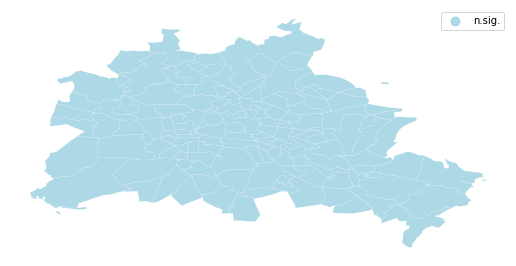

In [47]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['lightblue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [48]:
spots = ['n.sig.', 'diamond']
labels = [spots[i] for i in diamond*1]

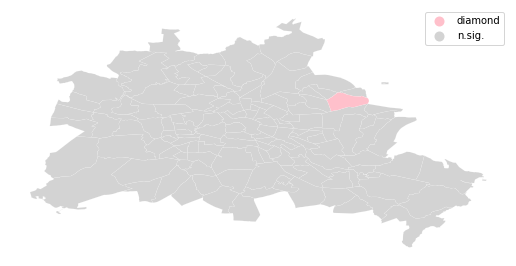

In [49]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['pink', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [50]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

array([1, 1, 0, 0, 0, 0, 3, 3, 0, 1, 0, 3, 3, 0, 3, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 3, 0,
       0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 3, 3, 3, 3, 3, 3, 1, 0, 1, 3, 3, 1, 1, 1, 0, 0, 0, 3, 0,
       1, 1, 1, 1, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 3, 3, 3, 0, 0, 0,
       4, 0, 0, 0, 0, 0, 0, 3])

In [51]:
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

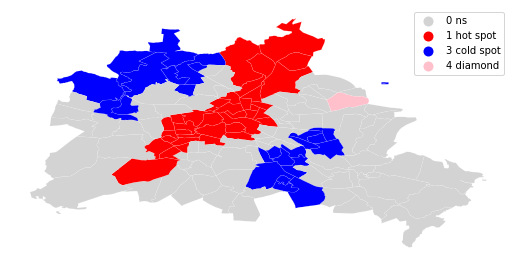

In [52]:

from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()